# EpiInfer-CONTACT: Complete Corrected Implementation (Algorithms 1–5)

In [ ]:
import numpy as np
import pandas as pd
import math
import random
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

Complete implementation of EpiInfer-CONTACT from the research paper:
| # | Name | Purpose |
|--:|------|----------|
| 1 | `CONTACTINFER-CORE` | One-day infection inference loop using contact tracing |
| 2 | `predict_exposures` | Predicts who becomes newly exposed given contacts |
| 3 | `find_prob_exposure` | Computes exposure probability per susceptible |
| 4 | `simulate_epiinfer_core` | Aggregate meeting-distribution version (uses mean contacts) |
| 5 | `continuous_calibrate` | Searches (p₁, p₂) to minimize RMSE on training data |

# UTILITY FUNCTIONS

In [ ]:
# ========== UTILITY FUNCTIONS ==========

def adjacency_from_pairs(contacts_per_day, population):
    """Convert contact pairs into adjacency dictionary for each day."""
    adj = {}
    for d, pairs in contacts_per_day.items():
        dayadj = {p: set() for p in population}
        for a, b in pairs:
            dayadj[a].add(b)
            dayadj[b].add(a)
        adj[d] = dayadj
    return adj

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return math.sqrt(mean_squared_error(y_true, y_pred))

# ========== ALGORITHM 3: FINDPROB ==========

def find_prob_exposure(adj_per_day, exposed_set, person, p1, day):
    """
    Algorithm 3 from paper: Calculate probability that susceptible person
    becomes exposed on given day based on contacts with exposed individuals.

    Returns: 1 - (1 - p1)^countEncounters
    """
    if day not in adj_per_day:
        return 0.0

    # Count encounters with exposed individuals
    encounters = len(adj_per_day[day].get(person, set()) & exposed_set)

    # Probability of NOT getting infected from all encounters
    return 1 - (1 - p1)**encounters if encounters > 0 else 0.0

# ========== ALGORITHM 2: PREDICT ==========

def predict_exposures(adj_per_day, BelExp_d, BelSusc_d, p1, day):
    """
    Algorithm 2 from paper: Predict who becomes newly exposed given contacts.

    Strategy:
    1. Calculate exposure probability for each susceptible
    2. Compute expected number N of new exposures
    3. Select top N individuals with highest exposure probability

    Returns: (set of newly exposed, dict of raw probabilities)
    """
    # Calculate exposure probability for each susceptible
    raw_probs = {s: find_prob_exposure(adj_per_day, BelExp_d, s, p1, day)
                 for s in BelSusc_d}

    # Expected number of newly exposed
    N = int(round(sum(raw_probs.values())))

    if N <= 0:
        return set(), raw_probs

    # Select top N individuals by probability
    sorted_susc = sorted(raw_probs.items(), key=lambda kv: -kv[1])
    chosen = {pid for pid, _ in sorted_susc[:N]}

    return chosen, raw_probs

# Main Class

In [ ]:
class EpiInferContact:
    """
    Main class implementing all EpiInfer-CONTACT algorithms.
    Supports both contact-tracing and meeting-distribution approaches.

    CHANGES:
    1. Class renamed from EpiInferCore to EpiInferContact
    2. Added duration_recovered parameter
    3. Smart initialization: exposed count = infected/p2, assigned by contact frequency
    4. Susceptible now excludes Recovered individuals
    """

    def __init__(self, population, contacts_per_day=None):
        """
        Initialize with population and optional contact tracing data.

        Parameters:
        - population: list of individual IDs
        - contacts_per_day: dict {day: [(person_a, person_b), ...]}
        """
        self.population = list(population)
        self.pop_set = set(population)
        self.contacts_adj = adjacency_from_pairs(contacts_per_day, population) if contacts_per_day else {}

    def _count_total_contacts(self, person):
        """Helper: Count total contacts for a person across all available days."""
        total = 0
        for day_adj in self.contacts_adj.values():
            total += len(day_adj.get(person, set()))
        return total

    def _initialize_exposed_from_infected(self, initial_infected, p2):
        """
        CHANGE 3: Smart initialization of exposed population.

        Strategy:
        - Estimate exposed count = len(initial_infected) / p2
        - Assign exposure to individuals with most contacts (highest risk)

        Returns: set of initially exposed individuals
        """
        # Estimate number of exposed based on infected count
        estimated_exposed_count = int(round(len(initial_infected) / p2)) if p2 > 0 else 0

        if estimated_exposed_count == 0:
            return set()

        # Exclude already infected from consideration
        candidates = self.pop_set - initial_infected

        if not candidates:
            return set()

        # Count total contacts for each candidate
        contact_counts = {person: self._count_total_contacts(person) for person in candidates}

        # Sort by contact count (descending) and select top N
        sorted_candidates = sorted(contact_counts.items(), key=lambda x: -x[1])
        exposed_count = min(estimated_exposed_count, len(sorted_candidates))
        initial_exposed = {person for person, _ in sorted_candidates[:exposed_count]}

        return initial_exposed

    # ========== ALGORITHM 1: CONTACTINFER-CORE (UPDATED) ==========

    def contactinfer_run(self, p1, p2, inc, initial_infected,
                         initial_exposed=None,
                         max_day=20,
                         duration_infected=7,
                         duration_recovered=14,
                         stochastic=True):
        """
        Algorithm 1 from paper: Main contact-tracing inference loop.

        UPDATES:
        1. Added duration_recovered parameter
        2. If initial_exposed not provided, compute it from initial_infected/p2
        3. Susceptible now excludes Recovered individuals

        Parameters:
        - p1: probability of exposure per contact with exposed person
        - p2: probability exposed person becomes infected
        - inc: incubation period (days)
        - initial_infected: set of initially infected individuals
        - initial_exposed: set of initially exposed (if None, computed from infected/p2)
        - max_day: number of days to simulate
        - duration_infected: how long someone stays infected
        - duration_recovered: how long someone stays recovered (immune)
        - stochastic: if True, use probabilistic sampling; if False, use expected values

        Returns: DataFrame with daily statistics
        """
        # CHANGE 3: Initialize exposed from infected if not provided
        if initial_exposed is None:
            initial_exposed = self._initialize_exposed_from_infected(initial_infected, p2)
            print(f"Initialized {len(initial_exposed)} exposed individuals based on {len(initial_infected)} infected (ratio: 1/{p2:.2f})")

        # Initialize tracking dictionaries
        self.BelNewExp = defaultdict(set)
        self.BelNewInf = defaultdict(set)
        self.BelNewRec = defaultdict(set)  # Track new recoveries
        self.BelExp = defaultdict(set)
        self.BelInf = defaultdict(set)
        self.BelRec = defaultdict(set)  # Track recovered individuals

        # Day 1 initialization
        self.BelNewExp[1] = set(initial_exposed)
        self.BelNewInf[1] = set(initial_infected)
        self.BelExp[1] = set(initial_exposed)
        self.BelInf[1] = set(initial_infected)
        self.BelRec[1] = set()

        records = []

        for d in range(1, max_day + 1):
            # Current state
            exp_d = self.BelExp[d]
            inf_d = self.BelInf[d]
            rec_d = self.BelRec[d]

            # CHANGE 4: Susceptible = Everyone - (Exposed ∪ Infected ∪ Recovered)
            susc_d = self.pop_set - (exp_d | inf_d | rec_d)

            # Algorithm 2: Predict new exposures
            new_exp, raw_probs = predict_exposures(self.contacts_adj, exp_d, susc_d, p1, d)
            self.BelNewExp[d + 1] = new_exp
            self.BelExp[d + 1] = exp_d | new_exp

            # Algorithm 1 Line 8: Infections from exposures inc days ago
            src_day = d + 1 - inc
            new_inf = set()

            if src_day >= 1:
                old_exp = self.BelNewExp[src_day]

                if stochastic:
                    # Each individual becomes infected with probability p2
                    new_inf = {e for e in old_exp if random.random() < p2}
                else:
                    # Deterministic approximation using expected value
                    k = int(round(p2 * len(old_exp)))
                    if k > 0 and len(old_exp) > 0:
                        new_inf = set(random.sample(list(old_exp), min(k, len(old_exp))))

            self.BelNewInf[d + 1] = new_inf

            # Active infections = all infections within duration window
            window_inf = range(max(1, d + 1 - duration_infected + 1), d + 2)
            active_inf = set().union(*[self.BelNewInf[t] for t in window_inf])
            self.BelInf[d + 1] = active_inf

            # NEW: Track recoveries (people who left infected state)
            recovery_day = d + 1 - duration_infected
            if recovery_day >= 1:
                new_rec = self.BelNewInf[recovery_day]
                self.BelNewRec[d + 1] = new_rec
            else:
                self.BelNewRec[d + 1] = set()

            # Active recovered = all recoveries within duration_recovered window
            window_rec = range(max(1, d + 1 - duration_recovered + 1), d + 2)
            active_rec = set().union(*[self.BelNewRec[t] for t in window_rec])
            self.BelRec[d + 1] = active_rec

            records.append({
                "day": d,
                "new_exposed": len(new_exp),
                "new_infected": len(new_inf),
                "new_recovered": len(self.BelNewRec[d + 1]),
                "total_exposed": len(self.BelExp[d + 1]),
                "total_infected": len(self.BelInf[d + 1]),
                "total_recovered": len(self.BelRec[d + 1]),
                "total_susceptible": len(susc_d),
                "expected_new_exposed": int(round(sum(raw_probs.values())))
            })

        return pd.DataFrame(records)

    # ========== ALGORITHM 4: EPIINFER-CORE ==========

    def simulate_epiinfer_core(self, p1, p2, inc, NewInf_hist, asymp_hist,
                              recovered_hist, mean_meetings, max_day):
        """
        Algorithm 4 from paper: Meeting-distribution based inference.

        Uses Equations 1-5 from the paper.

        Parameters:
        - p1: exposure probability per contact
        - p2: probability exposed becomes infected
        - inc: incubation period
        - NewInf_hist: dict {day: count} of initial infections
        - asymp_hist: dict {day: count} of asymptomatic population
        - recovered_hist: dict {day: count} of recovered population
        - mean_meetings: dict {day: average_contacts}
        - max_day: number of days to predict

        Returns: dict {day: predicted_new_infections}
        """
        NewInf = defaultdict(int, NewInf_hist)
        asymp = defaultdict(int, asymp_hist)
        recovered = defaultdict(int, recovered_hist)
        preds = {}

        for d in range(1, max_day + 1):
            t = d - inc

            # Before incubation period ends, use known values
            if t < 1:
                preds[d] = NewInf.get(d, 0)
                continue

            # === Equation (1): Probability already exposed at time t ===
            numerator = sum([NewInf.get(d - i, 0) for i in range(1, inc + 1)])
            denominator = p2 * max(1, asymp[t])
            palreadyexp = min(numerator / denominator, 1.0) if denominator > 0 else 0

            # === Equation (2): Probability of new exposure ===
            mean_contacts = mean_meetings.get(t, 0)
            p_newexposed = 1 - (1 - p1) ** (mean_contacts * palreadyexp)

            # === Equation (3): asymptomaticNotEx ===
            already_exposed_count = numerator / p2 if p2 > 0 else 0
            asymptomaticNotEx = (asymp[t]
                                - already_exposed_count
                                - recovered.get(t, 0))
            asymptomaticNotEx = max(0, asymptomaticNotEx)

            # === Equation (4): Expected newly exposed ===
            NewExposed = asymptomaticNotEx * p_newexposed

            # === Equation (5): Predicted new infections ===
            preds[d] = int(round(p2 * NewExposed))
            NewInf[d] = preds[d]

        return preds

    # ========== ALGORITHM 5: CONTINUOUSCALIBRATE ==========

    def continuous_calibrate(self, observed_newinf, inc, mean_meetings,
                           asymp_hist=None, recovered_hist=None,
                           p2_values=None, training_window=5, verbose=False):
        """
        Algorithm 5 from paper: Find optimal p1 and p2 parameters.

        Parameters:
        - observed_newinf: dict {day: count} of observed infections
        - inc: incubation period
        - mean_meetings: dict {day: average_contacts}
        - asymp_hist: dict {day: count} of asymptomatic population
        - recovered_hist: dict {day: count} of recovered population
        - p2_values: list of p2 values to test
        - training_window: number of recent days to use for RMSE
        - verbose: print progress

        Returns: dict with keys 'p1', 'p2', 'rmse'
        """
        if p2_values is None:
            p2_values = [round(x, 2) for x in np.arange(0.1, 1.01, 0.1)]

        # Setup default histories if not provided
        days = sorted(observed_newinf.keys())
        if asymp_hist is None:
            asymp_hist = {d: len(self.population) for d in days}
        if recovered_hist is None:
            recovered_hist = {d: 0 for d in days}

        # Training window
        end_day = max(days)
        start_day = max(1, end_day - training_window + 1)
        obs = [observed_newinf.get(d, 0) for d in range(start_day, end_day + 1)]

        best = {"p1": None, "p2": None, "rmse": float("inf")}

        # Grid search over p2
        for p2 in p2_values:
            lo, hi = 0.0, 1.0

            # Binary search for p1 (up to 15 iterations)
            for iteration in range(15):
                mid = (lo + hi) / 2.0

                # Run simulation with current parameters
                preds = self.simulate_epiinfer_core(
                    mid, p2, inc,
                    {1: observed_newinf.get(1, 0)},
                    asymp_hist,
                    recovered_hist,
                    mean_meetings,
                    end_day
                )

                # Calculate RMSE on training window
                pred = [preds.get(d, 0) for d in range(start_day, end_day + 1)]
                error = rmse(obs, pred)

                # Update best parameters
                if error < best["rmse"]:
                    best.update({"p1": mid, "p2": p2, "rmse": error})

                # Binary search update
                if np.mean(pred) > np.mean(obs):
                    hi = mid
                else:
                    lo = mid

            if verbose:
                print(f"p2={p2:.1f} → best_p1≈{best['p1']:.3f}, RMSE={best['rmse']:.3f}")

        return best

EXAMPLE 1: CONTACT-TRACING WITH SMART INITIALIZATION

EXAMPLE 1: Contact-Tracing with Smart Initialization

Smart Initialization Test:
Initial infected: {9}
p2 = 0.5
Initialized 2 exposed individuals based on 1 infected (ratio: 1/0.50)

Simulation Results:
    day  new_exposed  new_infected  new_recovered  total_susceptible  \
0     1            1             0              0                  7   
1     2            1             0              0                  6   
2     3            1             1              1                  5   
3     4            1             0              0                  4   
4     5            1             1              0                  3   
5     6            1             1              1                  2   
6     7            0             0              0                  1   
7     8            0             0              1                  1   
8     9            0             0              1                  2   
9    10            0             0              0                  2   
10   

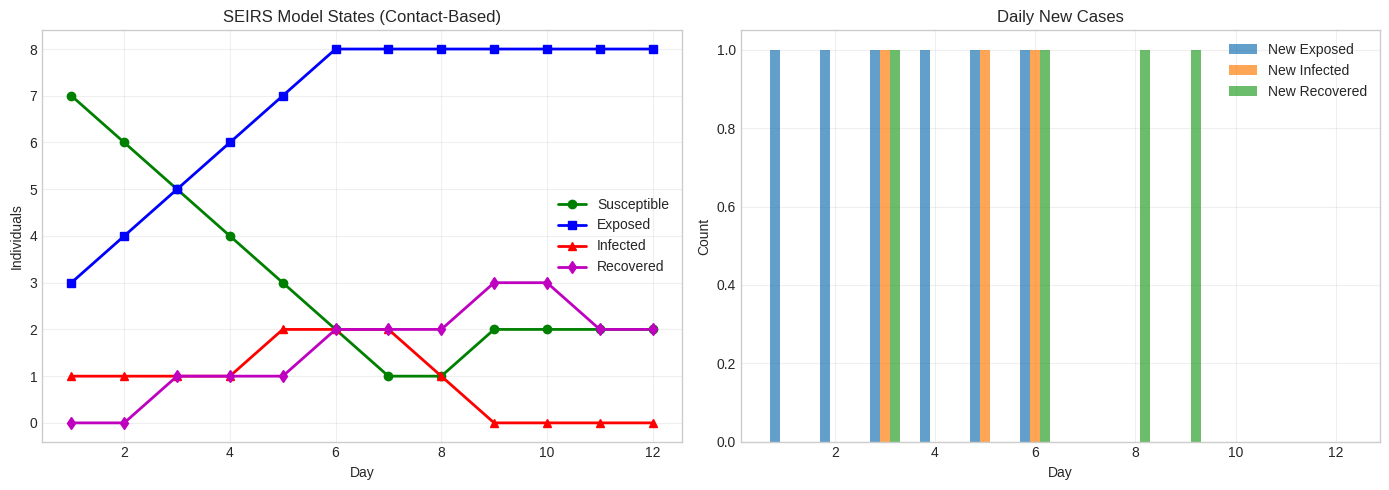

In [ ]:
print("="*60)
print("EXAMPLE 1: Contact-Tracing with Smart Initialization")
print("="*60)

population = list(range(10))
contacts = {
    1: [(0,1),(1,2),(2,3),(3,4)],
    2: [(0,2),(1,3),(2,4),(5,6)],
    3: [(1,4),(2,5),(3,6),(7,8)],
    4: [(0,3),(2,6),(4,7),(8,9)],
    5: [(1,5),(3,7),(4,8),(6,9)],
    6: [(0,4),(2,7),(5,8),(6,7)]
}

core = EpiInferContact(population, contacts)

# Test smart initialization
print("\nSmart Initialization Test:")
print(f"Initial infected: {{9}}")
print(f"p2 = 0.5")

df_contact = core.contactinfer_run(
    p1=0.3, p2=0.5, inc=2,
    initial_infected={9},  # No initial_exposed provided
    initial_exposed=None,   # Will be auto-computed
    max_day=12,
    duration_infected=3,
    duration_recovered=5,
    stochastic=True
)

print("\nSimulation Results:")
print(df_contact[['day', 'new_exposed', 'new_infected', 'new_recovered',
                  'total_susceptible', 'total_exposed', 'total_infected', 'total_recovered']])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: All states over time
ax1 = axes[0]
ax1.plot(df_contact["day"], df_contact["total_susceptible"], 'g-o', label="Susceptible", lw=2)
ax1.plot(df_contact["day"], df_contact["total_exposed"], 'b-s', label="Exposed", lw=2)
ax1.plot(df_contact["day"], df_contact["total_infected"], 'r-^', label="Infected", lw=2)
ax1.plot(df_contact["day"], df_contact["total_recovered"], 'm-d', label="Recovered", lw=2)
ax1.set_xlabel("Day")
ax1.set_ylabel("Individuals")
ax1.set_title("SEIRS Model States (Contact-Based)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: New cases per day
ax2 = axes[1]
ax2.bar(df_contact["day"] - 0.2, df_contact["new_exposed"], width=0.2, label="New Exposed", alpha=0.7)
ax2.bar(df_contact["day"], df_contact["new_infected"], width=0.2, label="New Infected", alpha=0.7)
ax2.bar(df_contact["day"] + 0.2, df_contact["new_recovered"], width=0.2, label="New Recovered", alpha=0.7)
ax2.set_xlabel("Day")
ax2.set_ylabel("Count")
ax2.set_title("Daily New Cases")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# EXAMPLE 2: MEETING-DISTRIBUTION SIMULATION

In [ ]:
print("\n" + "="*60)
print("EXAMPLE 2: Meeting-Distribution Simulation")
print("="*60)

mean_meetings = {d: np.random.uniform(1, 3) for d in range(1, 15)}
observed = {1:1, 2:2, 3:3, 4:5, 5:6, 6:5, 7:4, 8:3, 9:2, 10:2}
asymp_hist = {d: 50 for d in range(1, 15)}
recovered_hist = {d: 0 for d in range(1, 15)}

preds = core.simulate_epiinfer_core(
    p1=0.25, p2=0.5, inc=2,
    NewInf_hist=observed,
    asymp_hist=asymp_hist,
    recovered_hist=recovered_hist,
    mean_meetings=mean_meetings,
    max_day=14
)

df_preds = pd.DataFrame({
    "day": list(preds.keys()),
    "predicted_NewInf": list(preds.values())
})
print("\nMeeting-Distribution Predictions:")
print(df_preds.head(10))



EXAMPLE 2: Meeting-Distribution Simulation

Meeting-Distribution Predictions:
   day  predicted_NewInf
0    1                 1
1    2                 2
2    3                 1
3    4                 1
4    5                 1
5    6                 1
6    7                 1
7    8                 1
8    9                 1
9   10                 1


# EXAMPLE 3: PARAMETER CALIBRATION

In [ ]:
print("\n" + "="*60)
print("EXAMPLE 3: Parameter Calibration")
print("="*60)

best_params = core.continuous_calibrate(
    observed_newinf=observed,
    inc=2,
    mean_meetings=mean_meetings,
    asymp_hist=asymp_hist,
    recovered_hist=recovered_hist,
    training_window=5,
    verbose=True
)
print(f"\nBest parameters: p1={best_params['p1']:.4f}, p2={best_params['p2']:.2f}, RMSE={best_params['rmse']:.4f}")


EXAMPLE 3: Parameter Calibration
p2=0.1 → best_p1≈0.875, RMSE=1.844
p2=0.2 → best_p1≈0.812, RMSE=1.414
p2=0.3 → best_p1≈0.812, RMSE=1.414
p2=0.4 → best_p1≈0.812, RMSE=1.414
p2=0.5 → best_p1≈0.812, RMSE=1.414
p2=0.6 → best_p1≈0.812, RMSE=1.414
p2=0.7 → best_p1≈0.812, RMSE=1.414
p2=0.8 → best_p1≈0.812, RMSE=1.414
p2=0.9 → best_p1≈0.812, RMSE=1.414
p2=1.0 → best_p1≈0.812, RMSE=1.414

Best parameters: p1=0.8125, p2=0.20, RMSE=1.4142
